In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
torch.cuda.set_device(0)

In [5]:
PATH = "/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/"
sz = 64
arch = resnet34
bs = 128

In [6]:
label_csv = f'{PATH}counting_train_combined_final_csv.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
#val_idxs = get_cv_idxs(n) # random 20% data for validation set
val_idxs = np.loadtxt('/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/counting_val_idxs_final.csv', dtype=int)
label_csv
val_idxs

array([288734, 288735, 288736, ..., 324763, 324764, 324765])

In [7]:
import numpy as np
train_idxs = np.loadtxt('/home/ubuntu/efs/amazon-bin/code/workspace/fastai/courses/dl1/input/counting_train_idxs_final.csv', dtype=int)


In [8]:
len(val_idxs)

36032

In [9]:
len(train_idxs)

288734

In [10]:
label_df = pd.read_csv(label_csv)

In [11]:
label_df.count()
#PATH

idx      324766
count    324766
dtype: int64

In [12]:
label_df.pivot_table(index="count", aggfunc=len).sort_values('idx', ascending=False)

,idx
count,
3,81124
4,72407
2,69236
5,56152
1,37086
0,8761


In [13]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_final_csv.csv', 
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [14]:
fn = '/home/ubuntu/efs/amazon-bin/data/' + data.trn_ds.fnames[0]; fn

'/home/ubuntu/efs/amazon-bin/data/bin-images-resize/214752.jpg'

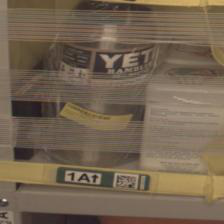

In [15]:
img = PIL.Image.open(fn); img


In [16]:
img.size

(224, 224)

In [17]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_final_csv.csv',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [18]:
data = get_data(sz, bs)

A Jupyter Widget

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [25]:
lrf=learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 1873/2256 [05:47<01:11,  5.39it/s, loss=3.22]

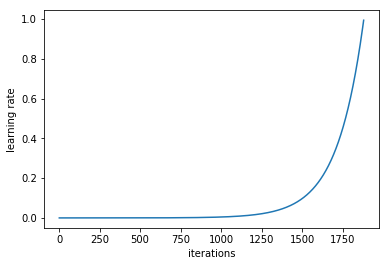

In [26]:
learn.sched.plot_lr()

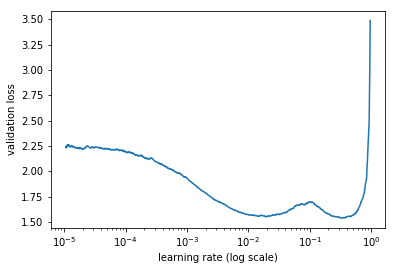

In [27]:
learn.sched.plot()

In [23]:
lr = 1e-3

In [30]:
learn.fit(lr, 1)

A Jupyter Widget

  0%|          | 1/2256 [00:01<47:47,  1.27s/it, loss=2.14]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      1.49992    1.462809   0.320659  



[array([ 1.46281]), 0.3206594138543517]

In [31]:
learn.save('res34_128_all_step0')

In [20]:
learn.load('res34_128_all_step0')

In [21]:
learn.precompute=False

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                       
    0      1.497729   1.45349    0.326571  
    1      1.481858   1.443292   0.327958                     
 35%|███▌      | 792/2256 [07:38<14:06,  1.73it/s, loss=1.48]

In [ ]:
learn.save('res34_128_step1')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [ ]:
learn.load('res34_128_step1')

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('res34_128_step2')

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz, bs))
learn.freeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 0.008
lr

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('res34_128_step3')

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=224

In [ ]:
learn.set_data(get_data(sz, bs))
learn.freeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('res34_128_step4')

In [ ]:
learn.load('res34_128_step4')

In [ ]:
learn.unfreeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
lrs

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('res34_128_step5')

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('resnet34-128-51')

In [ ]:
log_preds,y = learn.predict_with_targs()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False)


In [ ]:

plot_confusion_matrix(cm, data.classes)

In [ ]:
def get_data2(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv('/home/ubuntu/efs/amazon-bin/data/', 'bin-images-resize', f'{PATH}counting_train_combined_csv.csv',
                                       val_idxs=train_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


In [ ]:
data2 = get_data2(224, 128)

In [ ]:
learn.set_data(get_data2(224, 128))

In [ ]:
log_preds,y = learn.predict_with_targs()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
accuracy_np(preds,y)

In [ ]:
log_preds,y = learn.predict_with_targs()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
n = 0
perclass_correct = np.zeros(6) 
perclass_dist = np.zeros(6) 
perclass_N = np.zeros(6)
confusion_matrix = np.zeros((6,6), dtype=int)
for i in range(len(y)):
    pred = preds[i]
    gt = y[i]
            
    perclass_correct[gt] = perclass_correct[gt] + int(pred==gt) 
    perclass_dist[gt] = perclass_dist[gt] + np.power(pred-gt,2)
    perclass_N[gt] = perclass_N[gt] + 1
        
    confusion_matrix[gt][pred] += 1
        
    n = n+1

print('accuracy')
print('%d/%d (%f)' %(perclass_correct.sum(), perclass_N.sum(), perclass_correct.sum()/perclass_N.sum()))
print('RMSE(Root mean squared error)')
print(np.sqrt(perclass_dist.sum()/perclass_N.sum()))
print('Per class accuracy')
print(perclass_correct/perclass_N)
print('Per class RMSE')
print(np.sqrt(perclass_dist/perclass_N))
print(confusion_matrix)

Now creating plots for validation set with tta

In [ ]:
learn.set_data(get_data(224, 128))

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
learn.load('res34_128_step5')
sz=224

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.set_data(get_data(sz, bs))



In [ ]:
learn.unfreeze()

In [ ]:
learn.set_data(get_data(sz, bs))
learn.unfreeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
lrs

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('res34_128_step6')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
len(multi_preds)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [ ]:
preds

In [ ]:
# Confusion Matrix

predictions = np.argmax(preds, axis=1)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, predictions)

plot_confusion_matrix(cm, data.classes)

In [ ]:
print(len(y))
count = 0
for i in range(len(y)):
    if np.argmax(preds, axis=1)[i] == y[i]:
        count += 1
print(count)

In [ ]:
#53.8%

In [ ]:
sz=224
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [ ]:
learn.load('res34_128_step6')
learn.unfreeze()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = (1e-5)*2
lr

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)